In [ ]:
!unzip /content/drive/MyDrive/all_files.zip 


In [ ]:
mkdir /content/home/rishi

In [ ]:
mkdir /content/home/rphatan/new_numpy_files

In [ ]:
mkdir /content/home/rphatan/new_numpy_files/face_cut

In [ ]:
mkdir /content/home/rphatan/new_numpy_files/face_cut/numpy_files

In [ ]:
rm -r /content/home/rphatan/new_numpy_files/face_cut/

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
import numpy as np

In [ ]:
def get2Dprojection(original_image, axis=0):
    
    width = 128
    height = 128
    dim = (width, height)
    
    '''
    original_image : 3D numpy array containing brain image
    axis : 0 --> front, 1 --> bottom, 2 --> left, 3 --> right
    '''
    original_normalized = original_image/np.max(original_image)
    size = np.shape(original_image)
    if axis == 3:
        original_normalized = np.flip(original_normalized, (1, 2))
        image_size = [size[0], size[1]]
    elif axis == 0:
        image_size = [size[1], size[2]]
    elif axis == 1:
        original_normalized = np.flip(original_normalized, 1)
        image_size = [size[0], size[2]]
    else:
        image_size = [size[0], size[1]]
    image_outline = np.zeros(image_size)
    image = np.zeros(image_size)
    for i in range(image_size[0]):
        for j in range(image_size[1]):
            if axis == 0:
                vector = original_normalized[:,i,j]
            elif axis == 1:
                vector = original_normalized[i,:,j]
            else:
                vector = original_normalized[i,j,:]
            idx = (vector>0.05).argmax()
            image_outline[i][j]=idx
            image[i][j] = np.mean(vector[idx:idx+5])
    if axis == 0:
        image = np.flipud(image)/np.max(image)
        image_outline = np.flipud(image_outline)/size[0] * 2
    elif axis == 1:
        image = image.T/np.max(image)
        image_outline = image_outline.T/size[1] * 2
    elif axis == 2:
        image = np.flipud(image.T)/np.max(image)
        image_outline = np.flipud(image_outline.T)/size[2] * 2
    elif axis == 3:
        image = np.fliplr((image.T))/np.max(image)
        image_outline = np.fliplr(image_outline.T)/size[2] * 2
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA), image_outline

def run_2d_projection_main(files):
    import nibabel as nib
    import matplotlib.pyplot as plt
    import sys
    import glob

  
    for file in files:
        #file='C:/Users/akash/OneDrive/Desktop/bse/IXI066-Guys-0731-T1_bse_cut.nii.gz'
        original_image = nib.load(file).get_fdata()
        original_image=np.nan_to_num(original_image)
        image_front, image_outline_front = get2Dprojection(original_image, 0)
        image_left, image_outline_left = get2Dprojection(original_image, 2)
        image_right, image_outline_right = get2Dprojection(original_image, 3)
        image_bottom, image_outline_bottom = get2Dprojection(original_image, 1)
        #print(image_front.shape, image_left.shape, image_right.shape, image_bottom.shape)
        
        '''
        return np.hstack((np.resize(image_front,(width, height, 1)), 
                          np.resize(image_left,(width, height, 1)),
                          np.resize(image_right,(width, height, 1)), 
                          np.resize(image_bottom,(width, height, 1))))
        
        '''
        fig=plt.figure(figsize=(14, 10))
        columns = 4
        rows = 2
        ax=fig.add_subplot(rows, columns, 1)

        plt.imshow(image_front, cmap='gray', vmin=0, vmax=1,aspect="auto")
        # plt.figure(facecolor='white')

        fig.add_subplot(rows, columns, 2)
        plt.imshow(image_left, cmap='gray', vmin=0, vmax=1,aspect="auto")
        fig.add_subplot(rows, columns, 3)
        plt.imshow(image_right, cmap='gray', vmin=0, vmax=1,aspect="auto")
        fig.add_subplot(rows, columns, 4)
        plt.imshow(image_bottom, cmap='gray', vmin=0, vmax=1,aspect="auto")
        savefile=file.split('/')[-1].split('.')[0]+'.png'
        
        plt.savefig(savefile, bbox_inches='tight',pad_inches = 0)
        plt.close()
        # print("Done: "+str(savefile))
        '''
        #This code is for depth map
        plt.subplot(245)
        plt.imshow(image_outline_front, cmap='gray', vmin=0, vmax=1)
        plt.subplot(246)
        plt.imshow(image_outline_left, cmap='gray', vmin=0, vmax=1)
        plt.subplot(247)
        plt.imshow(image_outline_right, cmap='gray', vmin=0, vmax=1)
        plt.subplot(248)
        plt.imshow(image_outline_bottom, cmap='gray', vmin=0, vmax=1)
        '''
        #plt.show()



In [ ]:
files = ['/content/imgid-7084-sub-3.nii0.1.nii.gz']
import cv2
run_2d_projection_main(files)




In [ ]:

import pandas as pd
import glob
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import  layers,models
from sklearn.model_selection import KFold 
import os
import sklearn
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
%matplotlib inline

import matplotlib.pyplot as plt

face_train_acc = []
face_test_acc = []
train_losses = []
test_losses = []

val_loss = []
val_acc = []
test_acc = []


data=pd.read_csv('/content/combined.csv')

face_votes = data['Recognizable-Facial-Feature'].to_list()


face_votes_results = []
data_dir = '/content/home/rphatan/all_files'
full_2d_data = glob.glob(data_dir +'/*.png')
SEED = 220
random.seed(SEED)
random.shuffle(full_2d_data)


for index,item in enumerate(face_votes):
  if face_votes[index] == 'Yes':
      face_votes_results.append(1)
  elif face_votes[index] == 'No':
      face_votes_results.append(0)

names = []
for i in range(len(data)):
    na = data['Filename'][i]
    na = na.split('.')[0]
    na = na + '.png'
    names.append(na)
    
    
face_cut_dict = {}
for cur_index,files in enumerate(names):
    face_cut_dict[files]=face_votes_results[cur_index]

final_list=[]
for files in full_2d_data:
    key_to_search = files.split('/')[-1].strip()
    if key_to_search in face_cut_dict:
        final_list.append([files, face_cut_dict[key_to_search]])

k = 10
kf = KFold(n_splits=k,shuffle= True)
img_height = 128
img_width = 128
df = pd.DataFrame(final_list)
df.columns = ['name','data']
X = df['name']
y = df['data']


def build_model():
    face_model = models.Sequential()
    face_model.add(layers.Conv2D(8, (5, 5),strides = 2 ,activation='relu',padding='same', input_shape=(128, 128, 1)))
    face_model.add(layers.MaxPooling2D((2, 2),padding='same'))
    face_model.add(layers.Conv2D(16, (3, 3),strides = 2, activation='relu',padding='same'))
    face_model.add(layers.MaxPooling2D((2, 2),padding='same'))
    face_model.add(layers.Conv2D(32, (3, 3),strides = 1, activation='relu',padding='same'))
    face_model.add(layers.MaxPooling2D((2, 2),padding='same'))
    
    face_model.add(layers.Flatten())
    face_model.add(layers.Dense(32, activation='relu'))
    face_model.add(layers.Dense(1,activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    face_model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return face_model

def random_minibatch(train_files,batch_size):
    random_indices = np.random.choice(len(train_files), batch_size)
    return random_indices


main = []
val = []
path = '/content/home/rphatan/new_numpy_files/face_cut/numpy_files/'

test_indices = np.random.choice(len(final_list), int(len(final_list) * 0.2)  , replace=False)
testing_data = []

iter = 0

def model_training(train_files,validation_files,testing_data,current_k_value):
  face_model = 0

  face_model = build_model()

  face_train_acc = []
  val_acc = []
  test_acc = []

  train_losses = []
  val_loss = []
  test_losses = []

  train_p = 0 
  test_p = 0

  for epoch in range(0,20,1): # BATCH SIZE IS SET TO 128.    1648 observations are go into training and validation, # 1484 - training and 164 testing, 412 testing
    print("epoch ------------------",epoch)
    for epoch_iterations in range(0,25,1):

      train_p = random_minibatch(train_files,64)
      validation_p = random_minibatch(validation_files,64)
      test_p = random_minibatch(test_indices,64)


      train_data = []
      validation_data = []
      test_data = []

      
      for i in train_p:
        train_data.append(train_files[i])

      for i in validation_p:
        validation_data.append(validation_files[i])

      for i in test_p:
        test_data.append(testing_data[i])


      for i in test_data:
        if i in train_data:
          print("present in train data")
        elif i in validation_data:
          print("present in validation data")
        


    # <----------------------------------------------------------------------------------------------------------->
      x_train=[]
      y_train=[]

      for files in train_data:
          image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', target_size=(img_height, img_width))
          input_arr = tf.keras.preprocessing.image.img_to_array(image)
          x_train.append([input_arr])
          y_train.append([files[1]])

      x_train_ = 0
      y_train_ = 0
      x_train_ = np.reshape(np.array(x_train, dtype='float32'),(len(x_train),img_height,img_width,1))
      y_train_ = np.array(y_train, dtype='float32')


    # <----------------------------------------------------------------------------------------------------------->
      x_validation=[]
      y_validation=[]

      for files in validation_data:
          image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', 
                                                        target_size=(img_height, img_width))
          input_arr = tf.keras.preprocessing.image.img_to_array(image)
          x_validation.append([input_arr])
          y_validation.append([files[1]])

      x_validation_ = 0
      y_validation_ = 0
      x_validation_ = np.reshape(np.array(x_validation, dtype='float32'),(len(x_validation),img_height,img_width,1))
      y_validation_ = np.array(y_validation, dtype='float32')

    # <----------------------------------------------------------------------------------------------------------->
      x_test = []
      y_test = []
      for files in test_data:
          image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', 
                                                        target_size=(img_height, img_width))
          input_arr = tf.keras.preprocessing.image.img_to_array(image)
          x_test.append([input_arr])
          y_test.append([files[1]])

      x_test_ = 0
      y_test_ = 0
      x_test_ = np.reshape(np.array(x_test, dtype='float32'),(len(x_test),img_height,img_width,1))
      y_test_ = np.array(y_test, dtype='float32')


    # <----------------------------------------------------------------------------------------------------------->

      train_loss, train_accuracy = face_model.train_on_batch(x_train_, y_train_)
      validation_loss, validation_accuracy = face_model.test_on_batch(x_validation_,y_validation_)
      test_loss, test_accuracy = face_model.test_on_batch(x_test_,y_test_)

  # <----------------------------------------------------------------------------------------------------------->

      face_train_acc.append(train_accuracy)
      train_losses.append(train_loss)
  # <----------------------------------------------------------------------------------------------------------->

      val_acc.append(validation_accuracy)
      val_loss.append(validation_loss)
  # <----------------------------------------------------------------------------------------------------------->

      test_acc.append(test_accuracy)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
      test_losses.append(test_loss)
  
  face_model.save('/content/'+ 'current_k_value' + str(iter) +'.h5')

  return face_train_acc,val_acc,test_acc


main_train = []
main_test = []
main_val = []
k_iter = 1

for train_index , validation_index in kf.split(X): # k different subsets of data ::::: 1484 -- training observations ::: 164 -- testing observations

  train_files = []
  validation_files = []
  testing_data = []


  for i in train_index:
    if i in test_indices:
      pass
    else:
      train_files.append(final_list[i])
  
  for i in validation_index:
    if i in test_indices:
      pass
    else:
      validation_files.append(final_list[i])

  for i in test_indices:
    testing_data.append(final_list[i])

# <----------------------------------------------------------------------------------------------------------->

  model_training_acc,model_val_acc,model_testing_acc = model_training(train_files,validation_files,testing_data,k_iter)
  main_train.append(model_training_acc)
  main_test.append(model_testing_acc)
  main_val.append(model_val_acc)


  iter += 1
  

      

In [ ]:
test_indices

In [ ]:
testing_data = []
for i in test_indices:
  testing_data.append(final_list[i])

In [ ]:
x_t = []
y_t = []
for files in testing_data:
    image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', 
                                                  target_size=(img_height, img_width))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    x_t.append([input_arr])
    y_t.append([files[1]])

x_t_ = 0
y_t_ = 0
x_t_ = np.reshape(np.array(x_t, dtype='float32'),(len(x_t),img_height,img_width,1))
y_t_ = np.array(y_t, dtype='float32')


In [ ]:
model1.summary()

In [ ]:
from tensorflow import keras
model1 = tf.keras.models.load_model('/content/current_k_value0.h5')
model2 = tf.keras.models.load_model('/content/current_k_value1.h5')
model3 = tf.keras.models.load_model('/content/current_k_value2.h5')
model4 = tf.keras.models.load_model('/content/current_k_value3.h5')
model5 = tf.keras.models.load_model('/content/current_k_value4.h5')
model6 = tf.keras.models.load_model('/content/current_k_value5.h5')
model7 = tf.keras.models.load_model('/content/current_k_value6.h5')
model8 = tf.keras.models.load_model('/content/current_k_value7.h5')
model9 = tf.keras.models.load_model('/content/current_k_value8.h5')
model10 = tf.keras.models.load_model('/content/current_k_value9.h5')

y_pred1 = model1.predict(x_t_)
y_pred2 = model2.predict(x_t_)
y_pred3 = model3.predict(x_t_)
y_pred4 = model4.predict(x_t_)
y_pred5 = model5.predict(x_t_)
y_pred6 = model6.predict(x_t_)
y_pred7 = model7.predict(x_t_)
y_pred8 = model8.predict(x_t_)
y_pred9 = model9.predict(x_t_)
y_pred10 = model10.predict(x_t_)


confusion_matrix1 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred1))
confusion_matrix2 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred2))
confusion_matrix3 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred3))
confusion_matrix4 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred4))
confusion_matrix5 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred5))
confusion_matrix6 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred6))
confusion_matrix7 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred7))
confusion_matrix8 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred8))
confusion_matrix9 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred9))
confusion_matrix10 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred10))

auc1 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred1))
auc2 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred2))
auc3 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred3))
auc4 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred4))
auc5 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred5))
auc6 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred6))
auc7 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred7))
auc8 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred8))
auc9 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred9))
auc10 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred10))

fpr1, tpr1, threshold1 = sklearn.metrics.roc_curve(y_t_,  np.rint(y_pred1))
fpr2, tpr2, threshold2 = sklearn.metrics.roc_curve(y_t_,  np.rint(y_pred2))
fpr3, tpr3, threshold3 = sklearn.metrics.roc_curve(y_t_,  np.rint(y_pred3))
fpr4, tpr4, threshold4 = sklearn.metrics.roc_curve(y_t_,  np.rint(y_pred4))
fpr5, tpr5, threshold5 = sklearn.metrics.roc_curve(y_t_,  np.rint(y_pred5))
fpr6, tpr6, threshold6 = sklearn.metrics.roc_curve(y_t_,  np.rint(y_pred6))
fpr7, tpr7, threshold7 = sklearn.metrics.roc_curve(y_t_,  np.rint(y_pred7))
fpr8, tpr8, threshold8 = sklearn.metrics.roc_curve(y_t_,  np.rint(y_pred8))
fpr9, tpr9, threshold9 = sklearn.metrics.roc_curve(y_t_,  np.rint(y_pred9))
fpr10, tpr10, threshold10 = sklearn.metrics.roc_curve(y_t_,  np.rint(y_pred10))



In [ ]:
fpr1, tpr1, threshold1 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred1,2))
fpr2, tpr2, threshold2 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred2,2))
fpr3, tpr3, threshold3 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred3,2))
fpr4, tpr4, threshold4 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred4,2))
fpr5, tpr5, threshold5 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred5,2))
fpr6, tpr6, threshold6 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred6,2))
fpr7, tpr7, threshold7 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred7,2))
fpr8, tpr8, threshold8 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred8,2))
fpr9, tpr9, threshold9 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred9,2))
fpr10, tpr10, threshold10 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred10,2))

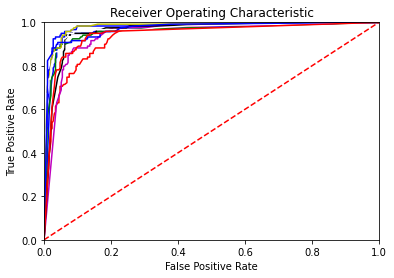

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b')
plt.plot(fpr2, tpr2, 'r')
plt.plot(fpr3, tpr3, 'g')
plt.plot(fpr4, tpr4, 'b')
plt.plot(fpr5, tpr5, 'y')
plt.plot(fpr6, tpr6, 'm')
plt.plot(fpr7, tpr7, 'k')
plt.plot(fpr8, tpr8, 'w')
plt.plot(fpr9, tpr9, 'b')
plt.plot(fpr10, tpr10, 'r')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
a = [auc1,auc2,auc3,auc4,auc5,auc6,auc7,auc8,auc9,auc10]

In [ ]:
confusion_matrix6

array([[265,  28],
       [ 14, 105]])

In [ ]:
for i in a:
  print(i)

0.9390828003556371
0.8496716092580376
0.9197808816359309
0.9482748730891675
0.9281842429804686
0.893394900622365
0.9355407692087073
0.93317463504173
0.9084951386698022
0.8876157971721113


In [ ]:
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred1)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred2)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred3)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred4)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred5)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred6)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred7)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred8)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred9)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred10)))

print("-----------------------------------------------------------------")

print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred1)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred2)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred3)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred4)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred5)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred6)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred7)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred8)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred9)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred10)))
print("-----------------------------------------------------------------")
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred1)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred2)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred3)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred4)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred5)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred6)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred7)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred8)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred9)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred10)))

print("-----------------------------------------------------------------")
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred1)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred2)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred3)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred4)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred5)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred6)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred7)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred8)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred9)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred10)))

0.941747572815534
0.8713592233009708
0.9320388349514563
0.9441747572815534
0.9368932038834952
0.8980582524271845
0.9296116504854369
0.9368932038834952
0.9053398058252428
0.9004854368932039
-----------------------------------------------------------------
0.8740157480314961
0.7661290322580645
0.8760330578512396
0.8636363636363636
0.8780487804878049
0.7894736842105263
0.8308823529411765
0.8661417322834646
0.7898550724637681
0.8095238095238095
-----------------------------------------------------------------
0.9327731092436975
0.7983193277310925
0.8907563025210085
0.957983193277311
0.907563025210084
0.8823529411764706
0.9495798319327731
0.9243697478991597
0.9159663865546218
0.8571428571428571
-----------------------------------------------------------------
0.9024390243902439
0.7818930041152263
0.8833333333333333
0.9083665338645418
0.8925619834710744
0.8333333333333333
0.8862745098039216
0.894308943089431
0.8482490272373541
0.8326530612244899


In [ ]:
!pip install plot-metric

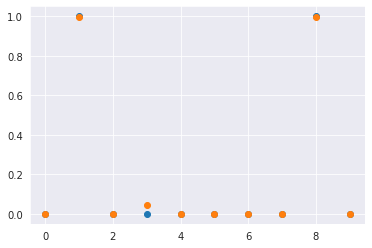

In [ ]:
plt.scatter(np.arange(0,10),y_t_[0:10])
plt.scatter(np.arange(0,10),y_pred1[0:10])

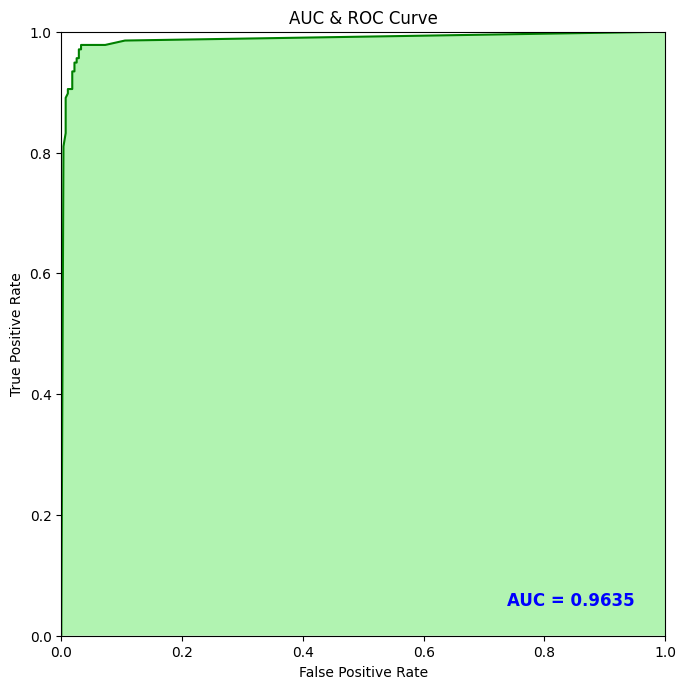

In [ ]:
plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(fpr3, tpr3, 'g')
plt.fill_between(fpr3, tpr3, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc3, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Text(0.5, 0, 'Observations')

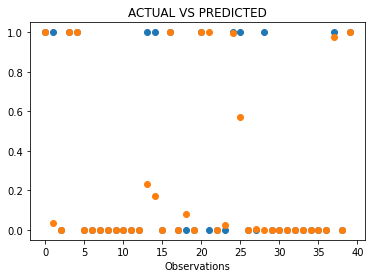

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(0,40),y_t_[0:40])
plt.scatter(np.arange(0,40),y_pred6[0:40])
plt.title("ACTUAL VS PREDICTED")
plt.xlabel("Observations")


In [ ]:
not good - 0,3,5,6,7,8,9

good - 1,2,4

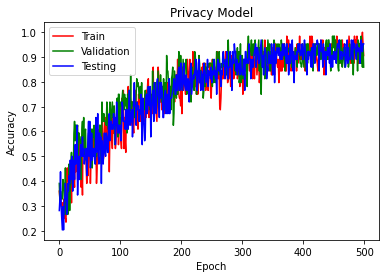

In [ ]:
plt.plot(np.arange(0,500),main_train[7],color='red')
plt.plot(np.arange(0,500),main_val[7],color='green')
plt.plot(np.arange(0,500),main_test[7],color='blue')


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.title('Privacy Model')

plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Testing'], loc='upper left')
plt.show()

In [ ]:
plt.plot(np.arange(0,500),face_train_acc,color='red')
plt.plot(np.arange(0,500),val_acc,color='green')
plt.plot(np.arange(0,500),test_acc,color='blue')


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.title('Face Cut Model (K = 10)')

plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Testing'], loc='upper left')
plt.show()

NameError: ignored

ValueError: ignored

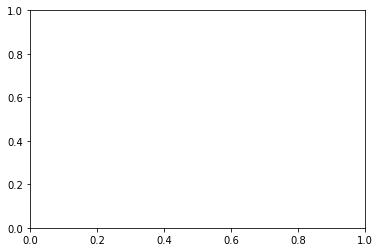

In [ ]:
plt.plot(np.arange(0,260),train_losses,color='red')
plt.plot(np.arange(0,260),val_loss,color='green')
plt.plot(np.arange(0,260),test_losses,color='blue')

plt.title('Face Cut Model (K = 10)')
plt.ylabel('Loss')

plt.xlabel('Epoch')
plt.legend(['Train','Validation','Test'], loc='upper left')
plt.show()

In [ ]:
daa

In [ ]:


x_t = []
y_t = []
for files in daa:
    image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', 
                                                  target_size=(img_height, img_width))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    x_t.append([input_arr])
    y_t.append([files[1]])

x_t_ = 0
y_t_ = 0
x_t_ = np.reshape(np.array(x_t, dtype='float32'),(len(x_t),img_height,img_width,1))
y_t_ = np.array(y_t, dtype='float32')


In [ ]:
from tensorflow import keras
model = tf.keras.models.load_model('/content/+f499.h5')
y_pred = model.predict(x_t_)

confusion_matrix = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred))


ValueError: ignored

In [ ]:
print(confusion_matrix)

[[244  18]
 [ 14 136]]


In [ ]:
print("{:.9f}".format(float(y_pred[8])))


0.000000012


In [ ]:
test_pro['calc_prob'] = flat_list

In [ ]:
test_pro.to_csv('/content/t.csv',index=False)